### Instalar dependencias

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=a011561a3322c1933864a23d726b0170ef394f8a7718283cb8f21d95c0b59178
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you ha

### Configuración del entorno

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from random import shuffle, choices
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import os
import re
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import torch
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
path = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_images')

In [ ]:
def label_func(fname):
    fname = str(fname)
    match = re.search(r'_(\d)_\.png$', fname)
    return int(match.group(1)) if match else 0

In [ ]:
from fastai.vision.all import *
import torch

In [ ]:
learn = load_learner('/content/drive/MyDrive/VIU/TFM/modelos/resnet50/modelo_resnet50_12epochs.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


#### Obtener predicción

In [ ]:
img_name = "7_test_1_.png"
img_name = "47_test_1_.png"

In [ ]:
# img_name = "80_test_1_.png" # tubos
img_name = "101_test_1_.png" # pulmon a la mitad
# img_name = "986_test_1_.png"

In [ ]:
img_route = path / img_name
pred_class, _, probs = learn.predict(img_route)
pred = int(pred_class)
print("pred", pred)

dl = learn.dls.test_dl([img_route])   # crea un dataloader de prueba
input_tensor = dl.one_batch()[0].to(device)

target_class = ClassifierOutputTarget(pred)
classes = [target_class]

pred 1


#### Obtener el modelo y últimas capas convolucionales

In [ ]:
# model[0][-1][-1] # probemos esto

In [ ]:
learn.model.to(device)
model = learn.model
model.eval()
last_conv_layer = model[0][-1][-1]
model = learn.model
layers = [last_conv_layer]

In [ ]:
model[0][-1][-1].conv3

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

#### Mostramos la imagen y la máscara de test

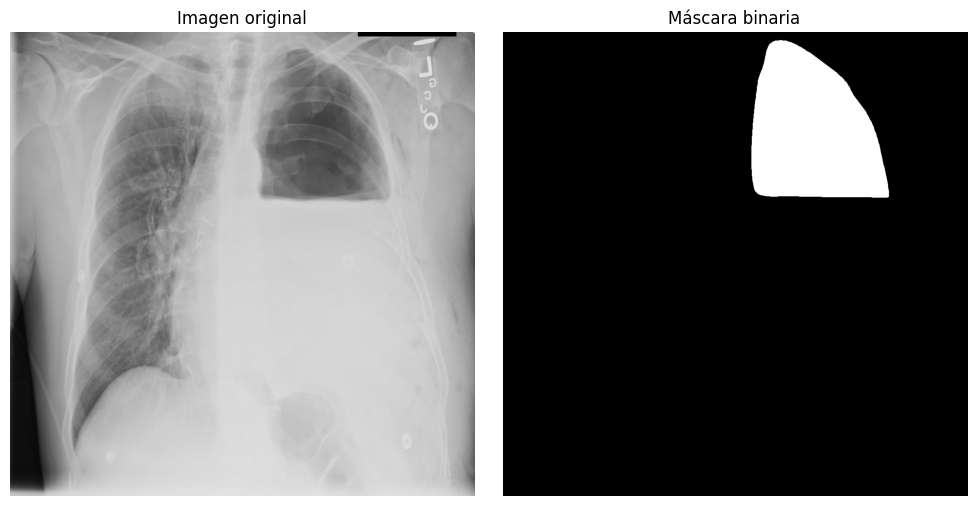

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen original y la máscara
original_img = Image.open(img_route).convert("RGB")
mask_path = path.parent / 'png_masks' / img_name
mask_img = Image.open(mask_path).convert("L")

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
axes[0].imshow(original_img)
axes[0].set_title("Imagen original")
axes[0].axis('off')

# Máscara binaria
axes[1].imshow(mask_img, cmap='gray')
axes[1].set_title("Máscara binaria")
axes[1].axis('off')

plt.tight_layout()
plt.show()

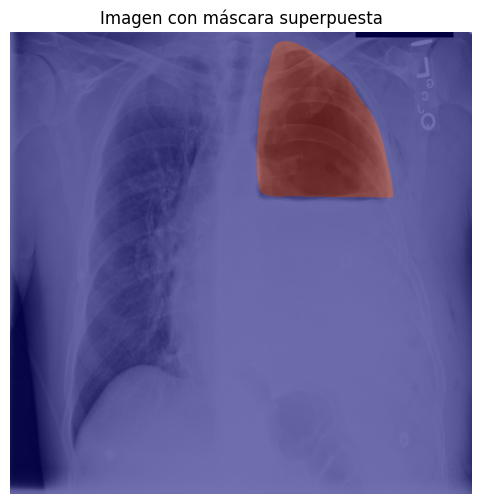

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Cargar imagen RGB y máscara en escala de grises
original_img = Image.open(img_route).convert("RGB")
mask_path = path.parent / 'png_masks' / img_name
mask_img = Image.open(mask_path).convert("L")  # blanco y negro

# Convertir a arrays para asegurar alineación
original_np = np.array(original_img)
mask_np = np.array(mask_img)

# Crear superposición
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(original_np)
ax.imshow(mask_np, cmap='jet', alpha=0.5)  # superposición con color y transparencia
ax.set_title("Imagen con máscara superpuesta")
ax.axis('off')
plt.show()

#### Comparación de CAM con Ground Truth

In [ ]:
def visualize_cam_comparison(img_name, cam_method, threshold):
    # Cargar imagen
    img_route = path / img_name
    image = Image.open(img_route).convert("RGB")
    mask_path = path.parent / 'png_masks' / img_name
    mask_img = Image.open(mask_path).convert("L")

    # Preprocesar
    dl = learn.dls.test_dl([img_route])   # crea un dataloader de prueba
    input_tensor = dl.one_batch()[0].to(device)
    # input_tensor = transform(original_img).unsqueeze(0).to(next(model.parameters()).device)

    # --- GradCAM ---
    cam = cam_method(model=model, target_layers=layers)
    gradcam_map = cam(input_tensor=input_tensor, targets=classes).squeeze()
    gradcam_map = (gradcam_map >= threshold).astype(float) * gradcam_map

    # Mostrar
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(image)
    axs[0].imshow(mask_img, cmap='jet', alpha=0.5)
    axs[0].set_title("Imagen original")
    axs[0].axis('off')

    axs[1].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1].imshow(gradcam_map, cmap='jet', alpha=0.5)
    axs[1].set_title(f"Threshold {threshold}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_all_cam_comparison(img_name):
    # Cargar imagen
    img_route = path / img_name
    image = Image.open(img_route).convert("RGB")
    mask_path = path.parent / 'png_masks' / img_name
    mask_img = Image.open(mask_path).convert("L")

    # Preprocesar
    dl = learn.dls.test_dl([img_route])   # crea un dataloader de prueba
    input_tensor = dl.one_batch()[0].to(device)
    # input_tensor = transform(original_img).unsqueeze(0).to(next(model.parameters()).device)

    # --- GradCAM ---
    gradcam = GradCAM(model=model, target_layers=layers)
    gradcam_map = gradcam(input_tensor=input_tensor, targets=classes).squeeze()
    gradcam_map = (gradcam_map >= 0.5).astype(float) * gradcam_map

    gradcampp = GradCAMPlusPlus(model=model, target_layers=layers)
    gradcampp_map = gradcampp(input_tensor=input_tensor, targets=classes).squeeze()
    gradcampp_map = (gradcampp_map >= 0.4).astype(float) * gradcampp_map

    eigencam = EigenCAM(model=model, target_layers=layers)
    eigencam_map = eigencam(input_tensor=input_tensor, targets=classes).squeeze()
    eigencam_map = (eigencam_map >= 0.5).astype(float) * eigencam_map

    xgradcam = XGradCAM(model=model, target_layers=layers)
    xgradcam_map = xgradcam(input_tensor=input_tensor, targets=classes).squeeze()
    xgradcam_map = (xgradcam_map >= 0.3).astype(float) * xgradcam_map

    # Mostrar
    fig, axs = plt.subplots(2, 3, figsize=(9, 7))

    axs[0][0].imshow(image)
    axs[0][0].imshow(mask_img, cmap='jet', alpha=0.3)
    axs[0][0].set_title("Imagen original")
    axs[0][0].axis('off')

    axs[0][1].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[0][1].imshow(gradcam_map, cmap='jet', alpha=0.5)
    axs[0][1].set_title(f"GradCAM")
    axs[0][1].axis('off')

    axs[0][2].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[0][2].imshow(gradcampp_map, cmap='jet', alpha=0.5)
    axs[0][2].set_title(f"GradCAM++")
    axs[0][2].axis('off')

    axs[1][0].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1][0].imshow(eigencam_map, cmap='jet', alpha=0.5)
    axs[1][0].set_title(f"EigenCAM")
    axs[1][0].axis('off')

    axs[1][1].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1][1].imshow(xgradcam_map, cmap='jet', alpha=0.5)
    axs[1][1].set_title(f"XGradCAM")
    axs[1][1].axis('off')

    axs[1][2].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1][2].imshow(eigencam_map, cmap='jet', alpha=0.5)
    axs[1][2].set_title(f"ScoreCAM")
    axs[1][2].axis('off')

    plt.tight_layout()
    plt.show()

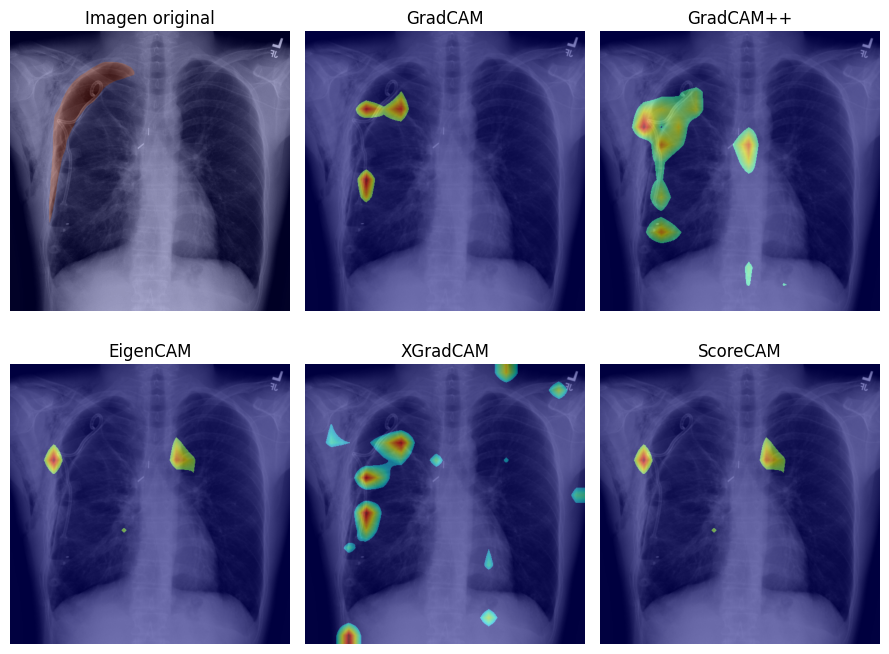

In [ ]:
visualize_all_cam_comparison("913_test_1_.png")

## Métricas

#### Definiciones

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

# Rutas
img_dir = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_images')
mask_dir = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_masks')

# Obtener imágenes de test con etiqueta positiva
image_files = [f for f in img_dir.iterdir() if "_test_1_" in f.name]

# Métricas
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def compute_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2 * intersection / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) != 0 else 0

In [ ]:
def method_metrics(camClass, image_files, cam_returns_heatmap=False,
                   target_layers=layers, target_class=ClassifierOutputTarget(pred)):
  # Resultados por imagen
  results = []

  # Iterar sobre las imágenes filtradas
  for img_path in image_files:
      print(f"Procesando: {img_path.name}")

      # Cargar imagen y máscara
      original_img = Image.open(img_path).convert("RGB")
      mask_path = mask_dir / img_path.name
      mask_img = Image.open(mask_path).convert("L")

      # Predicción
      pred_class, _, _ = learn.predict(img_path)
      pred = int(pred_class)
      if pred != 1:
          continue

      dl = learn.dls.test_dl([img_path])
      input_tensor = dl.one_batch()[0]

      cam = camClass(model=model, target_layers=target_layers)

      # Generar heatmap
      heatmap = cam(input_tensor=input_tensor, targets=[target_class])
      if cam_returns_heatmap == False:
        heatmap = heatmap[0]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

      # Preparar ground truth
      gt_mask = (np.array(mask_img) > 0).astype(np.uint8)
      heatmap_resized = resize(heatmap, gt_mask.shape, preserve_range=True)

      # Thresholds
      thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]

      metrics = {"image": img_path.name}

      for t in thresholds:
          binary_heatmap = (heatmap_resized >= t).astype(np.uint8)
          iou = compute_iou(binary_heatmap, gt_mask)
          dice = compute_dice(binary_heatmap, gt_mask)

          metrics[f"iou_t{t}"] = iou
          metrics[f"dice_t{t}"] = dice

      results.append(metrics)
      del heatmap, heatmap_resized, binary_heatmap, gt_mask

      # 💡 Liberar memoria
      try:
          del cam, heatmap, heatmap_resized, binary_heatmap, gt_mask, input_tensor
      except NameError:
          pass

  return results

### Obtener métricas de GRAD-CAM

In [ ]:
results = method_metrics(GradCAM, image_files)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_GRAD-CAM.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

Procesando: 914_test_1_.png


Procesando: 924_test_1_.png


Procesando: 920_test_1_.png


Procesando: 928_test_1_.png


Procesando: 949_test_1_.png


Procesando: 939_test_1_.png


Procesando: 941_test_1_.png


Procesando: 94_test_1_.png


Procesando: 942_test_1_.png


Procesando: 943_test_1_.png


Procesando: 938_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 977_test_1_.png


Procesando: 972_test_1_.png


Procesando: 988_test_1_.png


Procesando: 985_test_1_.png


Procesando: 990_test_1_.png


Procesando: 98_test_1_.png


Procesando: 982_test_1_.png


Procesando: 986_test_1_.png


Procesando: 99_test_1_.png


Procesando: 846_test_1_.png


Procesando: 852_test_1_.png


Procesando: 861_test_1_.png


Procesando: 858_test_1_.png


Procesando: 866_test_1_.png


Procesando: 878_test_1_.png


Procesando: 877_test_1_.png


Procesando: 86_test_1_.png


Procesando: 889_test_1_.png


Procesando: 894_test_1_.png


Procesando: 883_test_1_.png


Procesando: 893_test_1_.png


Procesando: 891_test_1_.png


Procesando: 886_test_1_.png


Procesando: 908_test_1_.png


Procesando: 89_test_1_.png


Procesando: 896_test_1_.png


Procesando: 911_test_1_.png


Procesando: 90_test_1_.png


Procesando: 913_test_1_.png


Procesando: 756_test_1_.png


Procesando: 758_test_1_.png


Procesando: 759_test_1_.png


Procesando: 763_test_1_.png


Procesando: 76_test_1_.png


Procesando: 776_test_1_.png


Procesando: 77_test_1_.png


Procesando: 784_test_1_.png


Procesando: 783_test_1_.png


Procesando: 791_test_1_.png


Procesando: 780_test_1_.png


Procesando: 785_test_1_.png


Procesando: 7_test_1_.png


Procesando: 814_test_1_.png


Procesando: 813_test_1_.png


Procesando: 80_test_1_.png


Procesando: 821_test_1_.png


Procesando: 831_test_1_.png


Procesando: 834_test_1_.png


Procesando: 826_test_1_.png


Procesando: 823_test_1_.png


Procesando: 671_test_1_.png


Procesando: 670_test_1_.png


Procesando: 705_test_1_.png


Procesando: 707_test_1_.png


Procesando: 703_test_1_.png


Procesando: 6_test_1_.png


Procesando: 694_test_1_.png


Procesando: 693_test_1_.png


Procesando: 717_test_1_.png


Procesando: 713_test_1_.png


Procesando: 718_test_1_.png


Procesando: 710_test_1_.png


Procesando: 726_test_1_.png


Procesando: 732_test_1_.png


Procesando: 722_test_1_.png


Procesando: 737_test_1_.png


Procesando: 740_test_1_.png


Procesando: 745_test_1_.png


Procesando: 74_test_1_.png


Procesando: 595_test_1_.png


Procesando: 588_test_1_.png


Procesando: 634_test_1_.png


Procesando: 630_test_1_.png


Procesando: 623_test_1_.png


Procesando: 605_test_1_.png


Procesando: 631_test_1_.png


Procesando: 64_test_1_.png


Procesando: 654_test_1_.png


Procesando: 653_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 645_test_1_.png


Procesando: 641_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 661_test_1_.png


Procesando: 667_test_1_.png


Procesando: 640_test_1_.png


Procesando: 687_test_1_.png


Procesando: 531_test_1_.png


Procesando: 526_test_1_.png


Procesando: 512_test_1_.png


Procesando: 520_test_1_.png


Procesando: 518_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 552_test_1_.png


Procesando: 550_test_1_.png


Procesando: 566_test_1_.png


Procesando: 572_test_1_.png


Procesando: 570_test_1_.png


Procesando: 557_test_1_.png


Procesando: 558_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 418_test_1_.png


Procesando: 424_test_1_.png


Procesando: 441_test_1_.png


Procesando: 435_test_1_.png


Procesando: 445_test_1_.png


Procesando: 446_test_1_.png


Procesando: 448_test_1_.png


Procesando: 452_test_1_.png


Procesando: 449_test_1_.png


Procesando: 469_test_1_.png


Procesando: 47_test_1_.png


Procesando: 483_test_1_.png


Procesando: 491_test_1_.png


Procesando: 476_test_1_.png


Procesando: 485_test_1_.png


Procesando: 506_test_1_.png


Procesando: 498_test_1_.png


Procesando: 500_test_1_.png


Procesando: 492_test_1_.png


Procesando: 509_test_1_.png


Procesando: 495_test_1_.png


Procesando: 37_test_1_.png


Procesando: 372_test_1_.png


Procesando: 364_test_1_.png


Procesando: 378_test_1_.png


Procesando: 356_test_1_.png


Procesando: 366_test_1_.png


Procesando: 376_test_1_.png


Procesando: 385_test_1_.png


Procesando: 415_test_1_.png


Procesando: 406_test_1_.png


Procesando: 387_test_1_.png


Procesando: 392_test_1_.png


Procesando: 42_test_1_.png


Procesando: 437_test_1_.png


Procesando: 432_test_1_.png


Procesando: 426_test_1_.png


Procesando: 287_test_1_.png


Procesando: 290_test_1_.png


Procesando: 284_test_1_.png


Procesando: 288_test_1_.png


Procesando: 266_test_1_.png


Procesando: 264_test_1_.png


Procesando: 279_test_1_.png


Procesando: 291_test_1_.png


Procesando: 301_test_1_.png


Procesando: 316_test_1_.png


Procesando: 315_test_1_.png


Procesando: 336_test_1_.png


Procesando: 340_test_1_.png


Procesando: 325_test_1_.png


Procesando: 337_test_1_.png


Procesando: 324_test_1_.png


Procesando: 322_test_1_.png


Procesando: 341_test_1_.png


Procesando: 19_test_1_.png


Procesando: 181_test_1_.png


Procesando: 193_test_1_.png


Procesando: 217_test_1_.png


Procesando: 204_test_1_.png


Procesando: 218_test_1_.png


Procesando: 219_test_1_.png


Procesando: 205_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 250_test_1_.png


Procesando: 25_test_1_.png


Procesando: 242_test_1_.png


Procesando: 263_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 146_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 145_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 152_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 147_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 17_test_1_.png


Procesando: 174_test_1_.png


Procesando: 160_test_1_.png


Procesando: 153_test_1_.png


Procesando: 156_test_1_.png


Procesando: 168_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 115_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 111_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1010_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1007_test_1_.png


✅ Proceso completado. Métricas guardadas.


Analizamos la media y desviación estándar de IOU y DICE para el método de explicabilidad

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_GRAD-CAM.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0065     0.0166     0.0124       0.0304    
0.4        0.0044     0.0130     0.0085       0.0245    
0.5        0.0030     0.0102     0.0057       0.0194    
0.5        0.0030     0.0102     0.0057       0.0194    
0.6        0.0017     0.0073     0.0032       0.0139    
0.6        0.0017     0.0073     0.0032       0.0139    
0.7        0.0004     0.0023     0.0008       0.0045    
0.8        0.0001     0.0007     0.0001       0.0014    
0.9        0.0000     0.0003     0.0000       0.0006    


Este es sin entrar a conv3

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0199     0.0415     0.0362       0.0692    
0.4        0.0160     0.0390     0.0290       0.0659    
0.5        0.0121     0.0357     0.0218       0.0602    
0.5        0.0121     0.0357     0.0218       0.0602    
0.6        0.0077     0.0276     0.0139       0.0468    
0.6        0.0077     0.0276     0.0139       0.0468    
0.7        0.0039     0.0169     0.0072       0.0299    
0.8        0.0015     0.0067     0.0029       0.0128    
0.9        0.0004     0.0018     0.0008       0.0036    


También podemos ver los resultados de forma gráfica

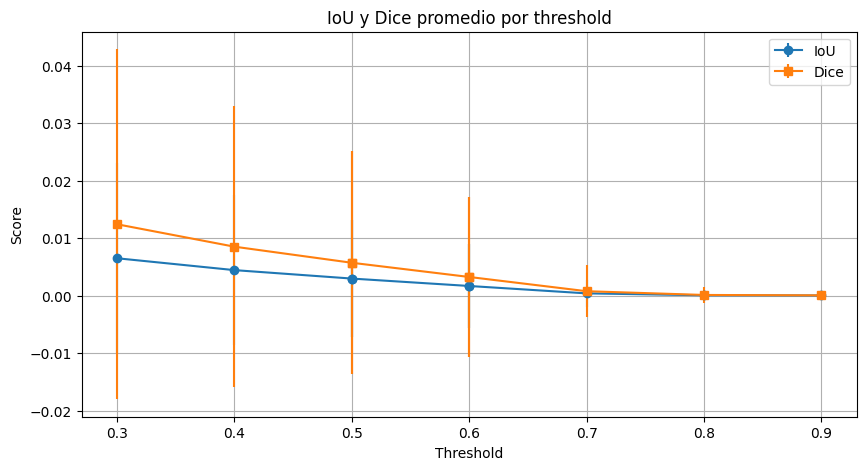

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()

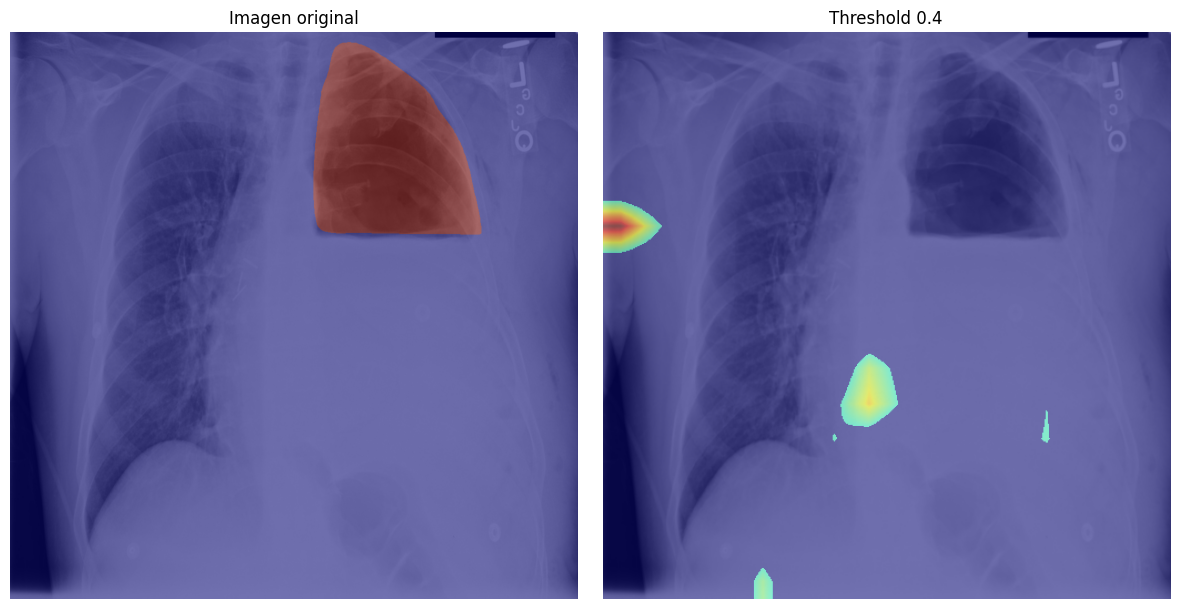

In [ ]:
visualize_cam_comparison("101_test_1_.png", GradCAM, 0.4)

### Obtener métricas de GRAD-CAM++

In [ ]:
results = method_metrics(GradCAMPlusPlus, image_files)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_GRAD-CAM++.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

Procesando: 914_test_1_.png


Procesando: 924_test_1_.png


Procesando: 920_test_1_.png


Procesando: 928_test_1_.png


Procesando: 949_test_1_.png


Procesando: 939_test_1_.png


Procesando: 941_test_1_.png


Procesando: 94_test_1_.png


Procesando: 942_test_1_.png


Procesando: 943_test_1_.png


Procesando: 938_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 977_test_1_.png


Procesando: 972_test_1_.png


Procesando: 988_test_1_.png


Procesando: 985_test_1_.png


Procesando: 990_test_1_.png


Procesando: 98_test_1_.png


Procesando: 982_test_1_.png


Procesando: 986_test_1_.png


Procesando: 99_test_1_.png


Procesando: 846_test_1_.png


Procesando: 852_test_1_.png


Procesando: 861_test_1_.png


Procesando: 858_test_1_.png


Procesando: 866_test_1_.png


Procesando: 878_test_1_.png


Procesando: 877_test_1_.png


Procesando: 86_test_1_.png


Procesando: 889_test_1_.png


Procesando: 894_test_1_.png


Procesando: 883_test_1_.png


Procesando: 893_test_1_.png


Procesando: 891_test_1_.png


Procesando: 886_test_1_.png


Procesando: 908_test_1_.png


Procesando: 89_test_1_.png


Procesando: 896_test_1_.png


Procesando: 911_test_1_.png


Procesando: 90_test_1_.png


Procesando: 913_test_1_.png


Procesando: 756_test_1_.png


Procesando: 758_test_1_.png


Procesando: 759_test_1_.png


Procesando: 763_test_1_.png


Procesando: 76_test_1_.png


Procesando: 776_test_1_.png


Procesando: 77_test_1_.png


Procesando: 784_test_1_.png


Procesando: 783_test_1_.png


Procesando: 791_test_1_.png


Procesando: 780_test_1_.png


Procesando: 785_test_1_.png


Procesando: 7_test_1_.png


Procesando: 814_test_1_.png


Procesando: 813_test_1_.png


Procesando: 80_test_1_.png


Procesando: 821_test_1_.png


Procesando: 831_test_1_.png


Procesando: 834_test_1_.png


Procesando: 826_test_1_.png


Procesando: 823_test_1_.png


Procesando: 671_test_1_.png


Procesando: 670_test_1_.png


Procesando: 705_test_1_.png


Procesando: 707_test_1_.png


Procesando: 703_test_1_.png


Procesando: 6_test_1_.png


Procesando: 694_test_1_.png


Procesando: 693_test_1_.png


Procesando: 717_test_1_.png


Procesando: 713_test_1_.png


Procesando: 718_test_1_.png


Procesando: 710_test_1_.png


Procesando: 726_test_1_.png


Procesando: 732_test_1_.png


Procesando: 722_test_1_.png


Procesando: 737_test_1_.png


Procesando: 740_test_1_.png


Procesando: 745_test_1_.png


Procesando: 74_test_1_.png


Procesando: 595_test_1_.png


Procesando: 588_test_1_.png


Procesando: 634_test_1_.png


Procesando: 630_test_1_.png


Procesando: 623_test_1_.png


Procesando: 605_test_1_.png


Procesando: 631_test_1_.png


Procesando: 64_test_1_.png


Procesando: 654_test_1_.png


Procesando: 653_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 645_test_1_.png


Procesando: 641_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 661_test_1_.png


Procesando: 667_test_1_.png


Procesando: 640_test_1_.png


Procesando: 687_test_1_.png


Procesando: 531_test_1_.png


Procesando: 526_test_1_.png


Procesando: 512_test_1_.png


Procesando: 520_test_1_.png


Procesando: 518_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 552_test_1_.png


Procesando: 550_test_1_.png


Procesando: 566_test_1_.png


Procesando: 572_test_1_.png


Procesando: 570_test_1_.png


Procesando: 557_test_1_.png


Procesando: 558_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 418_test_1_.png


Procesando: 424_test_1_.png


Procesando: 441_test_1_.png


Procesando: 435_test_1_.png


Procesando: 445_test_1_.png


Procesando: 446_test_1_.png


Procesando: 448_test_1_.png


Procesando: 452_test_1_.png


Procesando: 449_test_1_.png


Procesando: 469_test_1_.png


Procesando: 47_test_1_.png


Procesando: 483_test_1_.png


Procesando: 491_test_1_.png


Procesando: 476_test_1_.png


Procesando: 485_test_1_.png


Procesando: 506_test_1_.png


Procesando: 498_test_1_.png


Procesando: 500_test_1_.png


Procesando: 492_test_1_.png


Procesando: 509_test_1_.png


Procesando: 495_test_1_.png


Procesando: 37_test_1_.png


Procesando: 372_test_1_.png


Procesando: 364_test_1_.png


Procesando: 378_test_1_.png


Procesando: 356_test_1_.png


Procesando: 366_test_1_.png


Procesando: 376_test_1_.png


Procesando: 385_test_1_.png


Procesando: 415_test_1_.png


Procesando: 406_test_1_.png


Procesando: 387_test_1_.png


Procesando: 392_test_1_.png


Procesando: 42_test_1_.png


Procesando: 437_test_1_.png


Procesando: 432_test_1_.png


Procesando: 426_test_1_.png


Procesando: 287_test_1_.png


Procesando: 290_test_1_.png


Procesando: 284_test_1_.png


Procesando: 288_test_1_.png


Procesando: 266_test_1_.png


Procesando: 264_test_1_.png


Procesando: 279_test_1_.png


Procesando: 291_test_1_.png


Procesando: 301_test_1_.png


Procesando: 316_test_1_.png


Procesando: 315_test_1_.png


Procesando: 336_test_1_.png


Procesando: 340_test_1_.png


Procesando: 325_test_1_.png


Procesando: 337_test_1_.png


Procesando: 324_test_1_.png


Procesando: 322_test_1_.png


Procesando: 341_test_1_.png


Procesando: 19_test_1_.png


Procesando: 181_test_1_.png


Procesando: 193_test_1_.png


Procesando: 217_test_1_.png


Procesando: 204_test_1_.png


Procesando: 218_test_1_.png


Procesando: 219_test_1_.png


Procesando: 205_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 250_test_1_.png


Procesando: 25_test_1_.png


Procesando: 242_test_1_.png


Procesando: 263_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 146_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 145_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 152_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 147_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 17_test_1_.png


Procesando: 174_test_1_.png


Procesando: 160_test_1_.png


Procesando: 153_test_1_.png


Procesando: 156_test_1_.png


Procesando: 168_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 115_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 111_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1010_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1007_test_1_.png


✅ Proceso completado. Métricas guardadas.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_GRAD-CAM++.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0156     0.0279     0.0294       0.0501    
0.4        0.0137     0.0280     0.0257       0.0504    
0.5        0.0111     0.0268     0.0207       0.0480    
0.5        0.0111     0.0268     0.0207       0.0480    
0.6        0.0081     0.0233     0.0150       0.0419    
0.6        0.0081     0.0233     0.0150       0.0419    
0.7        0.0048     0.0186     0.0090       0.0338    
0.8        0.0026     0.0143     0.0049       0.0259    
0.9        0.0006     0.0044     0.0013       0.0085    


Este es sin entrar a conv3

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0239     0.0345     0.0445       0.0618    
0.4        0.0237     0.0392     0.0437       0.0694    
0.5        0.0210     0.0430     0.0381       0.0734    
0.5        0.0210     0.0430     0.0381       0.0734    
0.6        0.0154     0.0426     0.0275       0.0676    
0.6        0.0154     0.0426     0.0275       0.0676    
0.7        0.0083     0.0316     0.0148       0.0509    
0.8        0.0035     0.0161     0.0066       0.0287    
0.9        0.0013     0.0080     0.0025       0.0147    


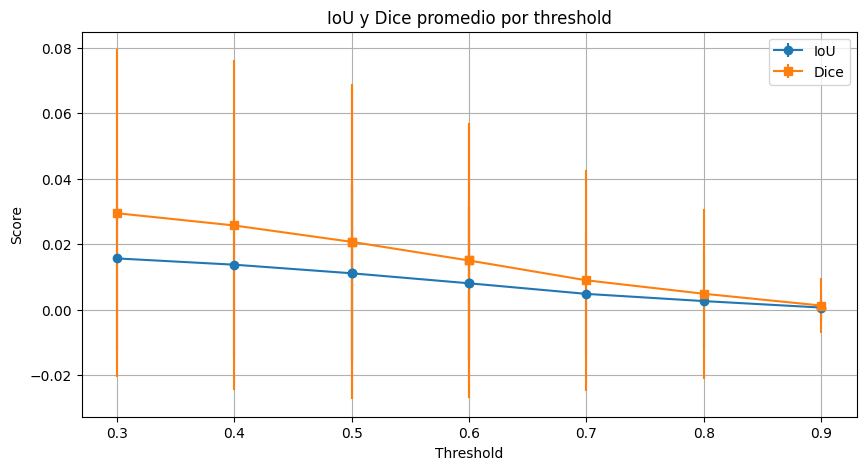

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()

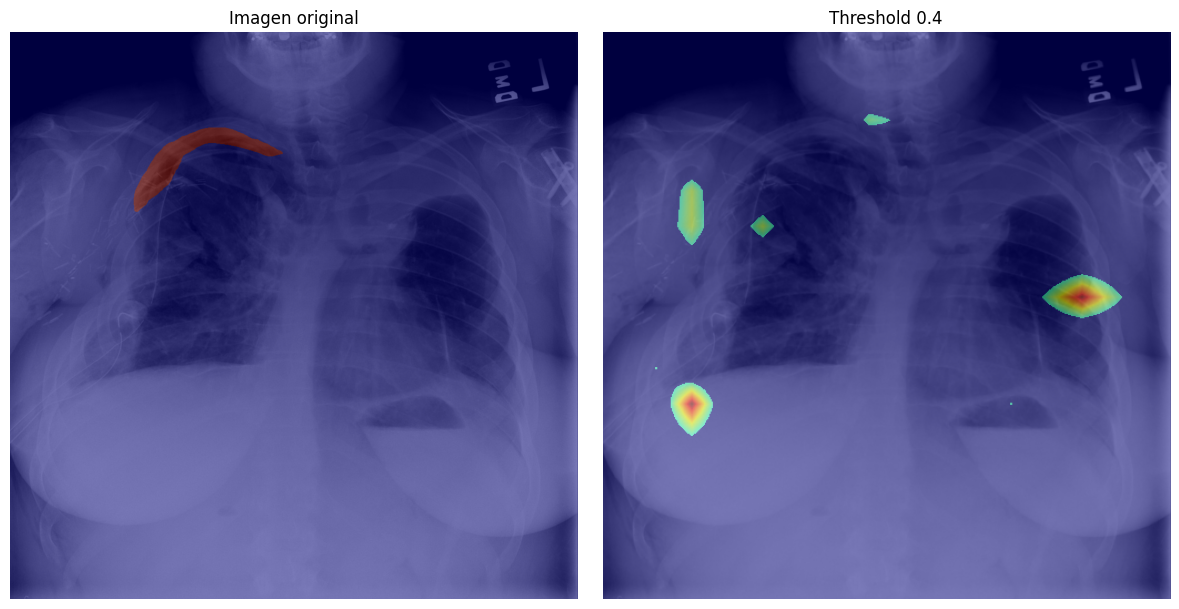

In [ ]:
visualize_cam_comparison("831_test_1_.png", GradCAMPlusPlus, 0.4)

### Obtener métricas de XGradCAM

In [ ]:
results = method_metrics(XGradCAM, image_files)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_XGradCAM.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

Procesando: 914_test_1_.png


Procesando: 924_test_1_.png


Procesando: 920_test_1_.png


Procesando: 928_test_1_.png


Procesando: 949_test_1_.png


Procesando: 939_test_1_.png


Procesando: 941_test_1_.png


Procesando: 94_test_1_.png


Procesando: 942_test_1_.png


Procesando: 943_test_1_.png


Procesando: 938_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 977_test_1_.png


Procesando: 972_test_1_.png


Procesando: 988_test_1_.png


Procesando: 985_test_1_.png


Procesando: 990_test_1_.png


Procesando: 98_test_1_.png


Procesando: 982_test_1_.png


Procesando: 986_test_1_.png


Procesando: 99_test_1_.png


Procesando: 846_test_1_.png


Procesando: 852_test_1_.png


Procesando: 861_test_1_.png


Procesando: 858_test_1_.png


Procesando: 866_test_1_.png


Procesando: 878_test_1_.png


Procesando: 877_test_1_.png


Procesando: 86_test_1_.png


Procesando: 889_test_1_.png


Procesando: 894_test_1_.png


Procesando: 883_test_1_.png


Procesando: 893_test_1_.png


Procesando: 891_test_1_.png


Procesando: 886_test_1_.png


Procesando: 908_test_1_.png


Procesando: 89_test_1_.png


Procesando: 896_test_1_.png


Procesando: 911_test_1_.png


Procesando: 90_test_1_.png


Procesando: 913_test_1_.png


Procesando: 756_test_1_.png


Procesando: 758_test_1_.png


Procesando: 759_test_1_.png


Procesando: 763_test_1_.png


Procesando: 76_test_1_.png


Procesando: 776_test_1_.png


Procesando: 77_test_1_.png


Procesando: 784_test_1_.png


Procesando: 783_test_1_.png


Procesando: 791_test_1_.png


Procesando: 780_test_1_.png


Procesando: 785_test_1_.png


Procesando: 7_test_1_.png


Procesando: 814_test_1_.png


Procesando: 813_test_1_.png


Procesando: 80_test_1_.png


Procesando: 821_test_1_.png


Procesando: 831_test_1_.png


Procesando: 834_test_1_.png


Procesando: 826_test_1_.png


Procesando: 823_test_1_.png


Procesando: 671_test_1_.png


Procesando: 670_test_1_.png


Procesando: 705_test_1_.png


Procesando: 707_test_1_.png


Procesando: 703_test_1_.png


Procesando: 6_test_1_.png


Procesando: 694_test_1_.png


Procesando: 693_test_1_.png


Procesando: 717_test_1_.png


Procesando: 713_test_1_.png


Procesando: 718_test_1_.png


Procesando: 710_test_1_.png


Procesando: 726_test_1_.png


Procesando: 732_test_1_.png


Procesando: 722_test_1_.png


Procesando: 737_test_1_.png


Procesando: 740_test_1_.png


Procesando: 745_test_1_.png


Procesando: 74_test_1_.png


Procesando: 595_test_1_.png


Procesando: 588_test_1_.png


Procesando: 634_test_1_.png


Procesando: 630_test_1_.png


Procesando: 623_test_1_.png


Procesando: 605_test_1_.png


Procesando: 631_test_1_.png


Procesando: 64_test_1_.png


Procesando: 654_test_1_.png


Procesando: 653_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 645_test_1_.png


Procesando: 641_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 661_test_1_.png


Procesando: 667_test_1_.png


Procesando: 640_test_1_.png


Procesando: 687_test_1_.png


Procesando: 531_test_1_.png


Procesando: 526_test_1_.png


Procesando: 512_test_1_.png


Procesando: 520_test_1_.png


Procesando: 518_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 552_test_1_.png


Procesando: 550_test_1_.png


Procesando: 566_test_1_.png


Procesando: 572_test_1_.png


Procesando: 570_test_1_.png


Procesando: 557_test_1_.png


Procesando: 558_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 418_test_1_.png


Procesando: 424_test_1_.png


Procesando: 441_test_1_.png


Procesando: 435_test_1_.png


Procesando: 445_test_1_.png


Procesando: 446_test_1_.png


Procesando: 448_test_1_.png


Procesando: 452_test_1_.png


Procesando: 449_test_1_.png


Procesando: 469_test_1_.png


Procesando: 47_test_1_.png


Procesando: 483_test_1_.png


Procesando: 491_test_1_.png


Procesando: 476_test_1_.png


Procesando: 485_test_1_.png


Procesando: 506_test_1_.png


Procesando: 498_test_1_.png


Procesando: 500_test_1_.png


Procesando: 492_test_1_.png


Procesando: 509_test_1_.png


Procesando: 495_test_1_.png


Procesando: 37_test_1_.png


Procesando: 372_test_1_.png


Procesando: 364_test_1_.png


Procesando: 378_test_1_.png


Procesando: 356_test_1_.png


Procesando: 366_test_1_.png


Procesando: 376_test_1_.png


Procesando: 385_test_1_.png


Procesando: 415_test_1_.png


Procesando: 406_test_1_.png


Procesando: 387_test_1_.png


Procesando: 392_test_1_.png


Procesando: 42_test_1_.png


Procesando: 437_test_1_.png


Procesando: 432_test_1_.png


Procesando: 426_test_1_.png


Procesando: 287_test_1_.png


Procesando: 290_test_1_.png


Procesando: 284_test_1_.png


Procesando: 288_test_1_.png


Procesando: 266_test_1_.png


Procesando: 264_test_1_.png


Procesando: 279_test_1_.png


Procesando: 291_test_1_.png


Procesando: 301_test_1_.png


Procesando: 316_test_1_.png


Procesando: 315_test_1_.png


Procesando: 336_test_1_.png


Procesando: 340_test_1_.png


Procesando: 325_test_1_.png


Procesando: 337_test_1_.png


Procesando: 324_test_1_.png


Procesando: 322_test_1_.png


Procesando: 341_test_1_.png


Procesando: 19_test_1_.png


Procesando: 181_test_1_.png


Procesando: 193_test_1_.png


Procesando: 217_test_1_.png


Procesando: 204_test_1_.png


Procesando: 218_test_1_.png


Procesando: 219_test_1_.png


Procesando: 205_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 250_test_1_.png


Procesando: 25_test_1_.png


Procesando: 242_test_1_.png


Procesando: 263_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 146_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 145_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 152_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 147_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 17_test_1_.png


Procesando: 174_test_1_.png


Procesando: 160_test_1_.png


Procesando: 153_test_1_.png


Procesando: 156_test_1_.png


Procesando: 168_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 115_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 111_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1010_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1007_test_1_.png


✅ Proceso completado. Métricas guardadas.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_XGradCAM.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0132     0.0247     0.0249       0.0446    
0.4        0.0119     0.0266     0.0224       0.0475    
0.5        0.0102     0.0264     0.0189       0.0468    
0.5        0.0102     0.0264     0.0189       0.0468    
0.6        0.0079     0.0252     0.0145       0.0448    
0.6        0.0079     0.0252     0.0145       0.0448    
0.7        0.0044     0.0166     0.0083       0.0305    
0.8        0.0021     0.0110     0.0039       0.0204    
0.9        0.0007     0.0052     0.0013       0.0099    


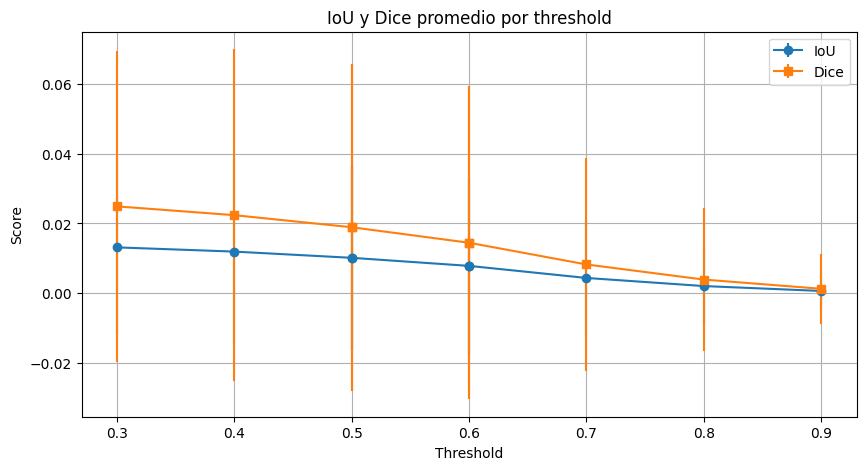

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()

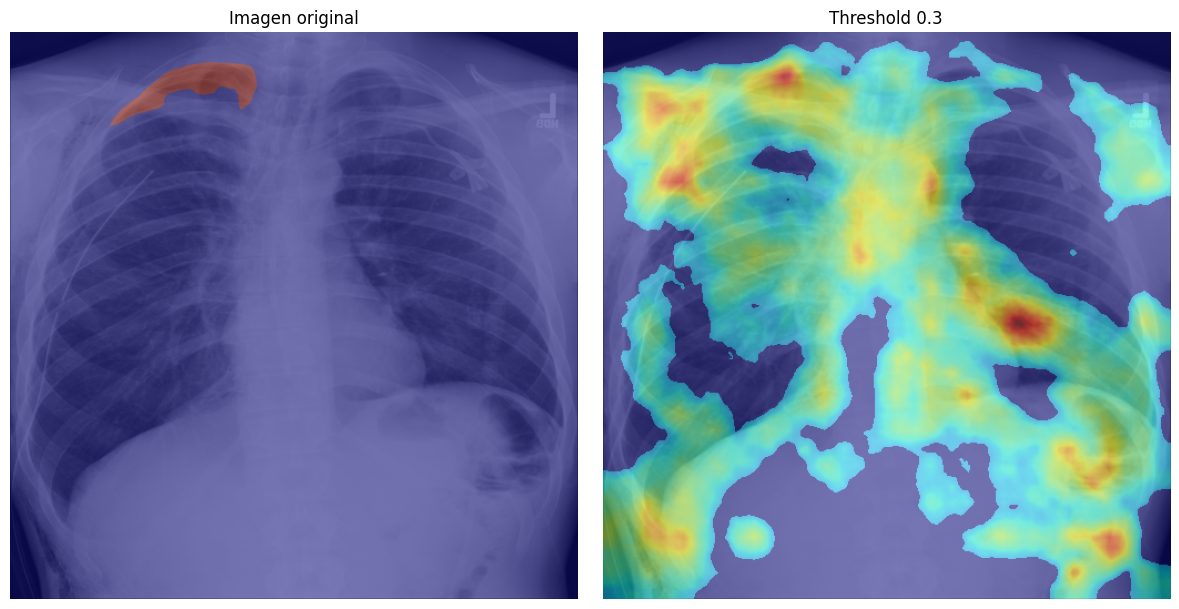

In [ ]:
visualize_cam_comparison("301_test_1_.png", FullGrad, 0.3)

### Obtener métricas de EigenCAM

In [ ]:
results = method_metrics(EigenCAM, image_files)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_EigenCAM.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

Procesando: 914_test_1_.png


Procesando: 924_test_1_.png


Procesando: 920_test_1_.png


Procesando: 928_test_1_.png


Procesando: 949_test_1_.png


Procesando: 939_test_1_.png


Procesando: 941_test_1_.png


Procesando: 94_test_1_.png


Procesando: 942_test_1_.png


Procesando: 943_test_1_.png


Procesando: 938_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 977_test_1_.png


Procesando: 972_test_1_.png


Procesando: 988_test_1_.png


Procesando: 985_test_1_.png


Procesando: 990_test_1_.png


Procesando: 98_test_1_.png


Procesando: 982_test_1_.png


Procesando: 986_test_1_.png


Procesando: 99_test_1_.png


Procesando: 846_test_1_.png


Procesando: 852_test_1_.png


Procesando: 861_test_1_.png


Procesando: 858_test_1_.png


Procesando: 866_test_1_.png


Procesando: 878_test_1_.png


Procesando: 877_test_1_.png


Procesando: 86_test_1_.png


Procesando: 889_test_1_.png


Procesando: 894_test_1_.png


Procesando: 883_test_1_.png


Procesando: 893_test_1_.png


Procesando: 891_test_1_.png


Procesando: 886_test_1_.png


Procesando: 908_test_1_.png


Procesando: 89_test_1_.png


Procesando: 896_test_1_.png


Procesando: 911_test_1_.png


Procesando: 90_test_1_.png


Procesando: 913_test_1_.png


Procesando: 756_test_1_.png


Procesando: 758_test_1_.png


Procesando: 759_test_1_.png


Procesando: 763_test_1_.png


Procesando: 76_test_1_.png


Procesando: 776_test_1_.png


Procesando: 77_test_1_.png


Procesando: 784_test_1_.png


Procesando: 783_test_1_.png


Procesando: 791_test_1_.png


Procesando: 780_test_1_.png


Procesando: 785_test_1_.png


Procesando: 7_test_1_.png


Procesando: 814_test_1_.png


Procesando: 813_test_1_.png


Procesando: 80_test_1_.png


Procesando: 821_test_1_.png


Procesando: 831_test_1_.png


Procesando: 834_test_1_.png


Procesando: 826_test_1_.png


Procesando: 823_test_1_.png


Procesando: 671_test_1_.png


Procesando: 670_test_1_.png


Procesando: 705_test_1_.png


Procesando: 707_test_1_.png


Procesando: 703_test_1_.png


Procesando: 6_test_1_.png


Procesando: 694_test_1_.png


Procesando: 693_test_1_.png


Procesando: 717_test_1_.png


Procesando: 713_test_1_.png


Procesando: 718_test_1_.png


Procesando: 710_test_1_.png


Procesando: 726_test_1_.png


Procesando: 732_test_1_.png


Procesando: 722_test_1_.png


Procesando: 737_test_1_.png


Procesando: 740_test_1_.png


Procesando: 745_test_1_.png


Procesando: 74_test_1_.png


Procesando: 595_test_1_.png


Procesando: 588_test_1_.png


Procesando: 634_test_1_.png


Procesando: 630_test_1_.png


Procesando: 623_test_1_.png


Procesando: 605_test_1_.png


Procesando: 631_test_1_.png


Procesando: 64_test_1_.png


Procesando: 654_test_1_.png


Procesando: 653_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 645_test_1_.png


Procesando: 641_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 661_test_1_.png


Procesando: 667_test_1_.png


Procesando: 640_test_1_.png


Procesando: 687_test_1_.png


Procesando: 531_test_1_.png


Procesando: 526_test_1_.png


Procesando: 512_test_1_.png


Procesando: 520_test_1_.png


Procesando: 518_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 552_test_1_.png


Procesando: 550_test_1_.png


Procesando: 566_test_1_.png


Procesando: 572_test_1_.png


Procesando: 570_test_1_.png


Procesando: 557_test_1_.png


Procesando: 558_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 418_test_1_.png


Procesando: 424_test_1_.png


Procesando: 441_test_1_.png


Procesando: 435_test_1_.png


Procesando: 445_test_1_.png


Procesando: 446_test_1_.png


Procesando: 448_test_1_.png


Procesando: 452_test_1_.png


Procesando: 449_test_1_.png


Procesando: 469_test_1_.png


Procesando: 47_test_1_.png


Procesando: 483_test_1_.png


Procesando: 491_test_1_.png


Procesando: 476_test_1_.png


Procesando: 485_test_1_.png


Procesando: 506_test_1_.png


Procesando: 498_test_1_.png


Procesando: 500_test_1_.png


Procesando: 492_test_1_.png


Procesando: 509_test_1_.png


Procesando: 495_test_1_.png


Procesando: 37_test_1_.png


Procesando: 372_test_1_.png


Procesando: 364_test_1_.png


Procesando: 378_test_1_.png


Procesando: 356_test_1_.png


Procesando: 366_test_1_.png


Procesando: 376_test_1_.png


Procesando: 385_test_1_.png


Procesando: 415_test_1_.png


Procesando: 406_test_1_.png


Procesando: 387_test_1_.png


Procesando: 392_test_1_.png


Procesando: 42_test_1_.png


Procesando: 437_test_1_.png


Procesando: 432_test_1_.png


Procesando: 426_test_1_.png


Procesando: 287_test_1_.png


Procesando: 290_test_1_.png


Procesando: 284_test_1_.png


Procesando: 288_test_1_.png


Procesando: 266_test_1_.png


Procesando: 264_test_1_.png


Procesando: 279_test_1_.png


Procesando: 291_test_1_.png


Procesando: 301_test_1_.png


Procesando: 316_test_1_.png


Procesando: 315_test_1_.png


Procesando: 336_test_1_.png


Procesando: 340_test_1_.png


Procesando: 325_test_1_.png


Procesando: 337_test_1_.png


Procesando: 324_test_1_.png


Procesando: 322_test_1_.png


Procesando: 341_test_1_.png


Procesando: 19_test_1_.png


Procesando: 181_test_1_.png


Procesando: 193_test_1_.png


Procesando: 217_test_1_.png


Procesando: 204_test_1_.png


Procesando: 218_test_1_.png


Procesando: 219_test_1_.png


Procesando: 205_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 250_test_1_.png


Procesando: 25_test_1_.png


Procesando: 242_test_1_.png


Procesando: 263_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 146_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 145_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 152_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 147_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 17_test_1_.png


Procesando: 174_test_1_.png


Procesando: 160_test_1_.png


Procesando: 153_test_1_.png


Procesando: 156_test_1_.png


Procesando: 168_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 115_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 111_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1010_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1007_test_1_.png


✅ Proceso completado. Métricas guardadas.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_EigenCAM.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0209     0.0267     0.0397       0.0490    
0.4        0.0213     0.0308     0.0399       0.0559    
0.5        0.0204     0.0343     0.0379       0.0604    
0.5        0.0204     0.0343     0.0379       0.0604    
0.6        0.0183     0.0359     0.0338       0.0625    
0.6        0.0183     0.0359     0.0338       0.0625    
0.7        0.0136     0.0312     0.0250       0.0553    
0.8        0.0055     0.0150     0.0105       0.0282    
0.9        0.0012     0.0056     0.0023       0.0108    


Este es sin entrar a conv3

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0125     0.0267     0.0234       0.0477    
0.4        0.0092     0.0202     0.0175       0.0375    
0.5        0.0062     0.0152     0.0120       0.0287    
0.5        0.0062     0.0152     0.0120       0.0287    
0.6        0.0038     0.0118     0.0073       0.0224    
0.6        0.0038     0.0118     0.0073       0.0224    
0.7        0.0025     0.0105     0.0048       0.0196    
0.8        0.0015     0.0077     0.0028       0.0146    
0.9        0.0004     0.0028     0.0009       0.0054    


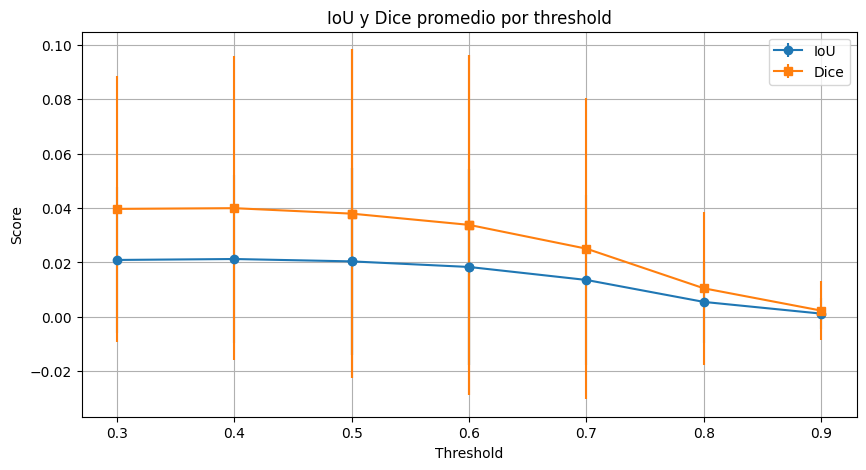

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()

### Obtener métricas de ScoreCAM

Usar una capa con menos canales:
En lugar de model.layer4[-1], usa model.layer3[-1] o anterior.

Aplicarlo a una muestra representativa del dataset, no a todas las imágenes si no es estrictamente necesario.

In [ ]:
# cam = ScoreCAM(model=model, target_layers=[model[0][0].denseblock1])

# Submuestreo aleatorio de 20 imágenes
random.seed(42)
sampled_images = random.sample(image_files, 40)

results = method_metrics(ScoreCAM, sampled_images)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_ScoreCAM.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

Procesando: 80_test_1_.png


 12%|█▎        | 8/64 [02:19<16:11, 17.34s/it]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_ScoreCAM.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0055     0.0188     0.0103       0.0354    
0.4        0.0041     0.0140     0.0077       0.0268    
0.5        0.0027     0.0094     0.0052       0.0182    
0.6        0.0016     0.0055     0.0031       0.0109    
0.7        0.0008     0.0027     0.0016       0.0054    


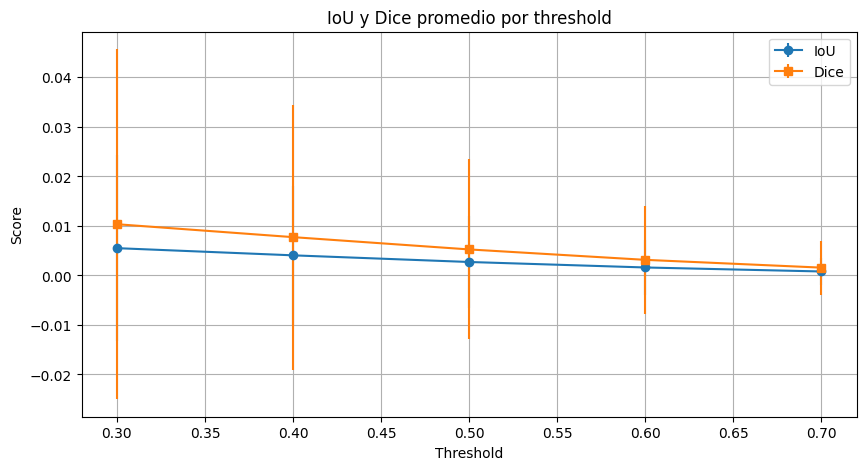

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()

### Obtener métricas de AblationCAM

In [ ]:
# cam = AblationCAM(model=model, target_layers=layers)
random.seed(42)
sampled_images = random.sample(image_files, 16)

results = method_metrics(AblationCAM, sampled_images)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_AblationCAM.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_AblationCAM.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0120     0.0121     0.0234       0.0234    
0.4        0.0128     0.0157     0.0248       0.0301    
0.5        0.0131     0.0197     0.0251       0.0374    
0.6        0.0136     0.0213     0.0261       0.0401    
0.7        0.0140     0.0252     0.0266       0.0471    


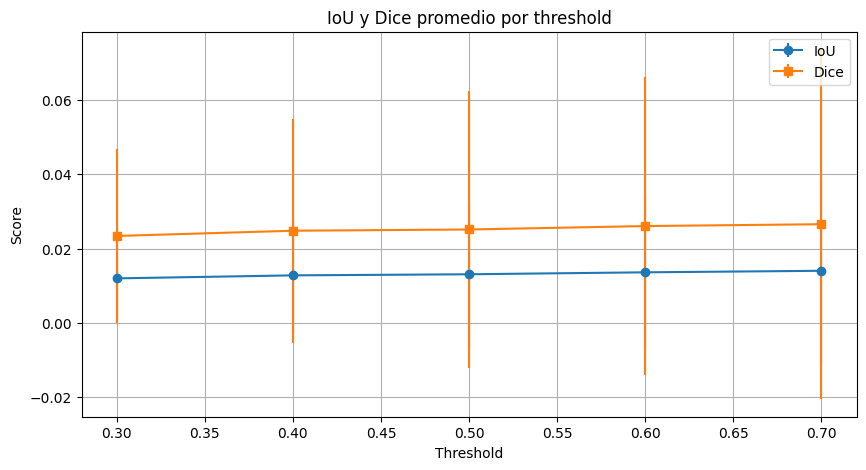

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()

### Obtener métricas de FullGrad

In [ ]:
# cam = FullGrad(model=model, target_layers=layers)

random.seed(42)
sampled_images = random.sample(image_files, 120)

results = method_metrics(FullGrad, sampled_images)

# Guardar resultados en DataFrame
df = pd.DataFrame(results)
df.to_csv("metricas_FullGrad.csv", index=False)

print("✅ Proceso completado. Métricas guardadas.")

Procesando: 80_test_1_.png


Procesando: 957_test_1_.png


Procesando: 372_test_1_.png


Procesando: 452_test_1_.png


Procesando: 557_test_1_.png


Procesando: 717_test_1_.png


Procesando: 780_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 759_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 985_test_1_.png


Procesando: 988_test_1_.png


Procesando: 776_test_1_.png


Procesando: 566_test_1_.png


Procesando: 424_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 977_test_1_.png


Procesando: 687_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 572_test_1_.png


Procesando: 152_test_1_.png


Procesando: 378_test_1_.png


Procesando: 928_test_1_.png


Procesando: 74_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 181_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 740_test_1_.png


Procesando: 550_test_1_.png


Procesando: 341_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 784_test_1_.png


Procesando: 250_test_1_.png


Procesando: 115_test_1_.png


Procesando: 631_test_1_.png


Procesando: 426_test_1_.png


Procesando: 703_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 958_test_1_.png


Procesando: 263_test_1_.png


Procesando: 598_test_1_.png


Procesando: 509_test_1_.png


Procesando: 894_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 656_test_1_.png


Procesando: 986_test_1_.png


Procesando: 364_test_1_.png


Procesando: 726_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 264_test_1_.png


Procesando: 288_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 663_test_1_.png


Procesando: 415_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 205_test_1_.png


Procesando: 990_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 337_test_1_.png


Procesando: 821_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 710_test_1_.png


Procesando: 174_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 831_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 858_test_1_.png


Procesando: 658_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 585_test_1_.png


Procesando: 291_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 665_test_1_.png


Procesando: 913_test_1_.png


Procesando: 645_test_1_.png


Procesando: 654_test_1_.png


Procesando: 785_test_1_.png


Procesando: 322_test_1_.png


Procesando: 6_test_1_.png


Procesando: 219_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 315_test_1_.png


Procesando: 98_test_1_.png


Procesando: 287_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 758_test_1_.png


Procesando: 492_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 823_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 418_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 694_test_1_.png


Procesando: 301_test_1_.png


Procesando: 217_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 813_test_1_.png


Procesando: 193_test_1_.png


Procesando: 588_test_1_.png


Procesando: 972_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 942_test_1_.png


Procesando: 745_test_1_.png


Procesando: 531_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 7_test_1_.png


Procesando: 376_test_1_.png


Procesando: 25_test_1_.png


Procesando: 147_test_1_.png


Procesando: 340_test_1_.png


Procesando: 469_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 316_test_1_.png


Procesando: 184_test_1_.png


Procesando: 908_test_1_.png


Procesando: 1027_test_1_.png


✅ Proceso completado. Métricas guardadas.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV generado
df = pd.read_csv("metricas_FullGrad.csv")

# Identificar los thresholds usados (extraer desde los nombres de columnas)
thresholds = [round(i, 1) for i in list(
    sorted({float(col.split('_t')[1]) for col in df.columns if 'iou_t' in col})
)]

# Calcular medias y stds para cada threshold
iou_means = []
iou_stds = []
dice_means = []
dice_stds = []

for t in thresholds:
    iou_col = f"iou_t{t}"
    dice_col = f"dice_t{t}"

    iou_means.append(df[iou_col].mean())
    iou_stds.append(df[iou_col].std())

    dice_means.append(df[dice_col].mean())
    dice_stds.append(df[dice_col].std())

In [ ]:
print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
print("-" * 60)
for i, t in enumerate(thresholds):
    print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0200     0.0229     0.0382       0.0424    
0.4        0.0207     0.0264     0.0394       0.0487    
0.5        0.0218     0.0342     0.0407       0.0613    
0.5        0.0218     0.0342     0.0407       0.0613    
0.6        0.0185     0.0332     0.0345       0.0597    
0.6        0.0185     0.0332     0.0345       0.0597    
0.7        0.0119     0.0296     0.0221       0.0535    
0.8        0.0059     0.0148     0.0114       0.0282    
0.9        0.0013     0.0040     0.0027       0.0079    


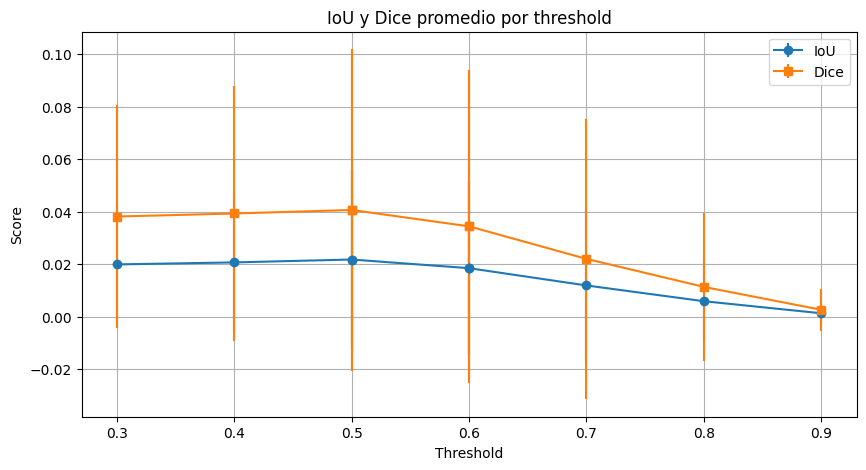

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(thresholds, iou_means, yerr=iou_stds, label="IoU", fmt='-o')
plt.errorbar(thresholds, dice_means, yerr=dice_stds, label="Dice", fmt='-s')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU y Dice promedio por threshold")
plt.legend()
plt.grid(True)
plt.show()